# Laboratory session 07

 Capettini Hilario (Matricola N. 2013031)

In [1]:
library("tibble")
library("tidyverse")
library("magrittr")
library(Bolstad2)
library(showtext)
showtext_auto()

set_plot_dimensions <- function(width_choice, height_choice) {
        options(repr.plot.width=width_choice, repr.plot.height=height_choice)
        }

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.3     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
✔ purrr   0.3.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract

Loading required package: sysfonts
Loading required package: showtextdb


## Exercise 1

-  a well established and diffused method for detecting a disease in blood fails to detect the presence of disease in 15% of the patients that actually have the disease.

-  A young UniPD startUp has developed an innovative method of screening. During the qualification phase, a random sample of $n = 75$ patients known to have the disease is screened using the new method.


In [2]:
set_plot_dimensions(8, 3)
prior_color     <- "#F8766D"
posterior_color <- "#00BFC4"
colors <- c('Prior' = prior_color, 'Posterior' = posterior_color)

###  what is the probability distribution of y, the number of times the new method fails to detect the disease ?


The binomial distribution is the discrete probability distribution of the number of successes in a sequence of $n$ INDEPENDENT experiments, each asking a yes–no question, and each with its own Boolean-valued outcome: success or failure.

###  on the n = 75 patients sample, the new method fails to detect the disease in y = 6 cases. What is the frequentist estimator of the failure probability of the new method ?

As presented during the lessons, in the frequentist approach, an unbiased estimator for the binomial distribution is $$p_F = \frac{y}{n}$$ where $y$ is the number of successes in $n$ trials. Furthermore the properties of this estimators are: 

$$E[p_F]= p$$ 

$$Var[p_F]=\frac{pq}{n}$$ 

$$MSE[p_F] = Bias[p_F,p]^2 + Var[p_F] = \frac{pq}{n}$$

In [3]:
y <- 6
n <- 75
estimator <- y/n

print(paste("The frequentist estimator of the failure probability of the new method is",estimator))

[1] "The frequentist estimator of the failure probability of the new method is 0.08"


### setup a bayesian computation of the posterior probability, assuming a beta distribution with mean value 0.15 and standard deviation 0.14. Plot the posterior distribution for y, and mark on the plot the mean value and variance


The relation between the beta distribution parameters $\alpha$ and $\beta$ and the distribution mean and standard deviation is known to be:

$$\mu= \frac{\alpha}{\alpha + \beta}$$

$$\sigma^2 = \frac{\alpha \beta}{(\alpha + \beta)^2(\alpha + \beta +1)}$$

those two relation can be easily inverted to obtain the parameters given certain values for the mean and the standard deviation

$$\alpha = \left[\frac{\mu(1-\mu)}{\sigma^2}-1 \right]\mu$$

$$\beta = \alpha \left(\frac{1}{\mu}-1\right)$$

In [4]:
mean_prior  <- 0.15; std_prior   <- 0.14
alpha_prior <-(mean_prior * (1-mean_prior) / std_prior**2 -1) * mean_prior
beta_prior  <-alpha_prior * (1/mean_prior -1)


As we know beta is the conjugate distribution for a binomial likelihood wit parameters parameters $\alpha_{posterior}= \alpha_{prior} +y $ and $\beta_{posterior} = \beta_{prior}+n-y$

In [5]:
n <- 75
y <- 6

alpha_posterior <- alpha_prior + y
beta_posterior  <- beta_prior  + n - y

p <- seq(0,1,0.001)
prior     <- dbeta(p,alpha_prior,beta_prior)
posterior <- dbeta(p,alpha_posterior,beta_posterior)

df <- data.frame(p, prior,posterior)

In [6]:
mean_posterior      <- (alpha_posterior) / (alpha_posterior + beta_posterior)
variance_posterior  <-  (alpha_posterior*beta_posterior)/((alpha_posterior+beta_posterior)**2 * (alpha_posterior + beta_posterior + 1))

Warning message:
“Removed 850 row(s) containing missing values (geom_path).”Warning message:
“Removed 850 row(s) containing missing values (geom_path).”

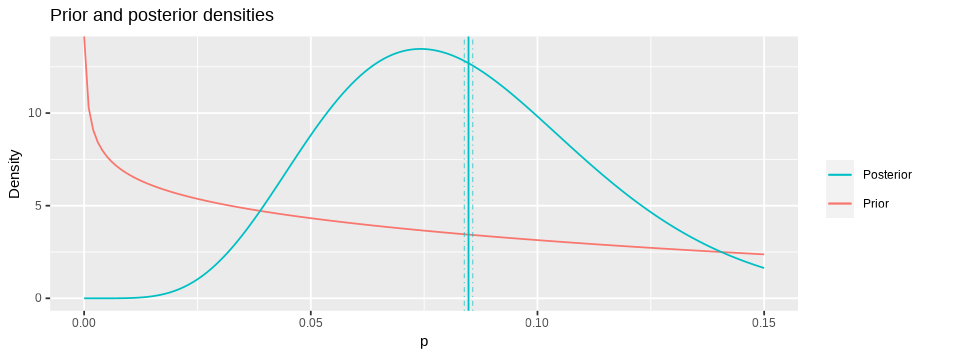

In [7]:
ggplot(df, aes(x = p)) +
    geom_line (aes(y = prior, color = 'Prior')) +
   # geom_line (aes(y = likelihood, color = 'Likelihood')) +
    geom_line (aes(y = posterior, color = 'Posterior')) +
    geom_vline(xintercept = mean_posterior, color=posterior_color, size = 0.5)+
    geom_vline(xintercept = mean_posterior + variance_posterior, color=posterior_color, linetype="dotdash", size = 0.2)+
    geom_vline(xintercept = mean_posterior - variance_posterior, color=posterior_color, linetype="dotdash", size = 0.2)+
    xlim(0,0.15)+
    labs(title ="Prior and posterior densities",
         x = "p",
         y = "Density",
         color = "") +
    scale_color_manual(values = colors)

In [8]:
print(paste("Te mean value for the posterior is ",sprintf("%.4f",mean_posterior),
            "with a variance of",sprintf("%1.2E",variance_posterior)))

[1] "Te mean value for the posterior is  0.0848 with a variance of 9.52E-04"


###  Perform a test of hypothesis assuming that if the probability of failing to the detect the desease in ill patients is greater or equal than 15%, the new test is no better that the traditional method. Test the sample at a 5% level of significance in the Bayesian way.


we wish to test $$H_0\,:\, P_{UNIPD} \leq P_{OLD}$$ at a level of significance $\alpha=0.05$.

For this purpose we integrate the posterior $$P(H_0: P_{UNIPD}\,\leq \, P_{OLD}|y) = \int_{0}^{P_{OLD}} g(p\,|\,y)\,dp $$

In [9]:
integral <- function(x,f,p,a){
    
    posterior_integral  <- sintegral(x,f)
    d  <- abs(posterior_integral$y-p)                       #Just a trick to convert our area of interest into a trackleable minimum
    i <-posterior_integral$x[max((1:length(posterior_integral$y))[d==min(d)])]
    return(i)}

one_side_hipothesis_evaluation <- function(area,a) {
    if (area > a){
    cat(paste("The result",sprintf("%.4f",area),"is higher than alpha =",a,"therefore we cannot reject the null hypothesis at",
           alpha * 100,"% level of significance.","\n"))
    
    }else{cat(paste("The result",sprintf("%.4f",a),"is lower than alpha =",a,"therefore we reject the null hypothesis at",
           alpha*100,"% level of significance."))}
}

The result 0.0534 is higher than alpha = 0.05 therefore we cannot reject the null hypothesis at 5 % level of significance. 


Warning message:
“Removed 800 row(s) containing missing values (geom_path).”

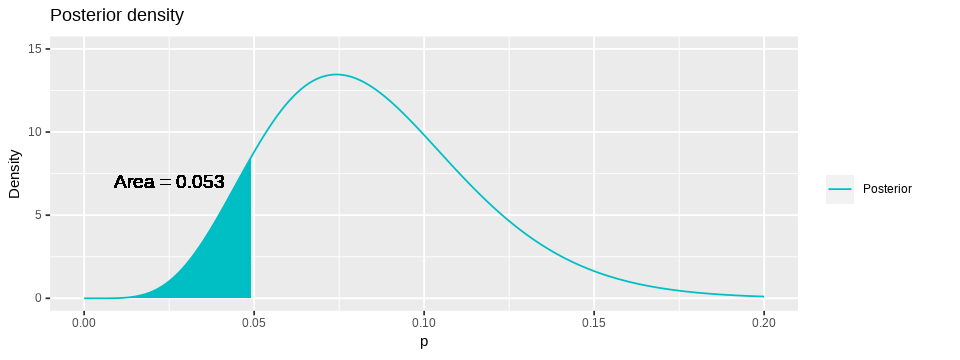

In [10]:
p_old <- 0.15
alpha <- 0.05
estimation <- integral(p,posterior,p_old,alpha)
one_side_hipothesis_evaluation(estimation,alpha)

ggplot(df, aes(x = p)) +
    geom_line (aes(y = posterior, color = 'Posterior')) +
    geom_area(mapping = aes(y=posterior,x = ifelse(p>0.0 & p< alpha , p, 0.0)), fill = posterior_color)+
    geom_text(mapping=aes(x=0.025, y=7, label=sprintf("Area = %.3f",estimation)),colour="black", size=5)+
    xlim(0,0.20)+ylim(0,15)+
    labs(title ="Posterior density",
         x = "p",
         y = "Density",
         color = "") +
    scale_color_manual(values = colors)

###  Perform the same hypothesis test in the classical frequentist way.


In [11]:
#
binom.test(x=y, n=n, p=0.15)



	Exact binomial test

data:  y and n
number of successes = 6, number of trials = 75, p-value = 0.1047
alternative hypothesis: true probability of success is not equal to 0.15
95 percent confidence interval:
 0.02992514 0.16603687
sample estimates:
probability of success 
                  0.08 


As the probability of success (failure of the test in our case) is lower that 15 percent we cannot reject the null hypothesis.

-

-

-

-

-

## Exercise 2

- Ladislaus Josephovich Bortkiewicz was a Russian economist and statistician. He noted that the Poisson distribution can be very useful in applied statistics when describing low-frequency events in a large population. In a famous example he showed that the number of deaths by horse kick among the Prussian army follows the Poisson distribution.
 
- Considering the following to sets of observations taken over a fixed large time interval in two different corps:

<table>
  <tr>
    <td> y death soldiers;</td>
    <td>0</td>
    <td>1</td>
    <td>2</td>
    <td>3</td>
    <td>4</td>
    <td>$\gt 5$</td>
  </tr>
  <tr>
    <td>$n_1$ observations</td>
    <td>109</td>
    <td>65</td>
    <td>22</td>
    <td>3</td>
    <td>1</td>
    <td>$0$</td>
  </tr>
  <tr>
    <td>$n_2$ observations</td>
    <td>144</td>
    <td>91</td>
    <td>32</td>
    <td>11</td>
    <td>2</td>
    <td>$0$</td>
  </tr>
</table>
 
 
 <a href="https://www.mun.ca/biology/scarr/smcPoisson_distributions.html#:~:text=In%20a%20classic%20example%2C%20Bortkiewicz,men%20were%20kicked%20to%20death">This is an explanatory link for the data</a>. 

In [12]:
set_plot_dimensions(8, 3)
color_n1     <- "#F8766D"
color_n2     <- "#00BFC4"
colors <- c('n1' = color_n1, 'n2' = color_n2)

In [13]:
#df <- data.frame()
death_soldiers <-c(0,1,2,3,4,5)
n1 <- c(109,65,22,3,1,0)
n2 <- c(144,91,32,11,2,0)
data <- data.frame(death_soldiers,n1,n2)

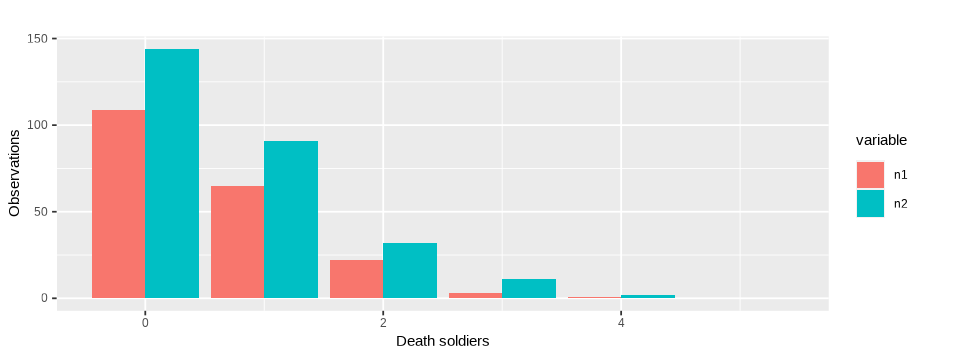

In [14]:
dfm <- pivot_longer(data, -death_soldiers, names_to="variable", values_to="value")
ggplot(dfm,aes(x = death_soldiers,y = value)) + 
    geom_bar(aes(fill = variable),stat = "identity",position = "dodge")+
    
labs(title ="",
         x = "Death soldiers",
         y = "Observations",
         color = "Set")

###  assuming a uniform prior, compute and plot the posterior distribution for $\lambda$, the death rate over the measurement time. Determine the posterior mean, median and variance, and compute the 95% credibility interval.


The uniform prior can be represented by a beta distribution with parameters $\alpha=1$, $\beta=1$.

In [15]:
#The following is a list of usefull functions for the problem

gamma_mean <- function(a,b) return(a/b)

#Given that there is no simple expression for the gamma(a,b) median we
#obtain it numerically
posterior_median <- function(p,posterior) {
    integral  <- sintegral(p,posterior)
    d  <- abs(integral$y-0.5)                       #Just a trick to convert our area of interest into a trackleable minimum
    estimation <-integral$x[max((1:length(integral$y))[d==min(d)])]
    return(estimation)}

gamma_variance <- function(a,b) return(a/(b**2))

credibility_interval <- function(credibility,p,posterior){
    #credibility must be between 0 and 1
    cdf  <- sintegral(p,posterior)
    a <- (1-credibility)/2
    b <- (credibility + a)
    d<-abs(cdf$y-a)
    posterior.min <- cdf$x[max((1:length(cdf$y))[d==min(d)])]

    d<-abs(cdf$y-b)
    posterior.max <- cdf$x[max((1:length(cdf$y))[d==min(d)])]
    return(c(posterior.min,posterior.max))
    
}

print_results <- function(prior,dataset,mean,median,variance,interval) {
    cat("---------------------------------","\n")
    cat(paste("Type of prior:",prior),"\n")
    cat(paste("Dataset:      ",dataset),"\n")
    cat("---------------------------------","\n")
    
    cat(paste("Mean   ",sprintf("%.3f",mean)),"\n")
    cat(paste("Median ",sprintf("%.3f",median)),"\n")
    cat(paste("Variance ",sprintf("%.3f",variance)),"\n")
    cat(paste("95% confidence interval ","[",sprintf("%.3f",interval[1]),",",sprintf("%.3f",interval[2]),"]"),"\n")

}

In [16]:
#Values of alpha and beta for both datasets

lambda <- seq(0,40,0.01)
alpha_n1_u <- 1 + sum(data$n1 * data$death_soldiers)
beta_n1_u  <- length(data$n1)
alpha_n2_u <- 1+sum(data$n2 * data$death_soldiers)
beta_n2_u  <- length(data$n2)

#Posterior estimations
posterior_uniform_n1 <- dgamma(lambda,alpha_n1_u,beta_n1_u)
posterior_uniform_n2 <- dgamma(lambda,alpha_n2_u,beta_n2_u)

results <- data.frame(lambda, posterior_uniform_n1,posterior_uniform_n2)

In [17]:
#Statistics
n1_mean_u     <- gamma_mean(alpha_n1_u,beta_n1_u)
n1_variance_u <-gamma_variance(alpha_n1_u,beta_n1_u)
n1_median_u   <- posterior_median(lambda,posterior_uniform_n1)
n1_interval_u <- credibility_interval(0.95,lambda,posterior_uniform_n1)

n2_mean_u <- gamma_mean(alpha_n2_u,beta_n2_u)
n2_variance_u <-gamma_variance(alpha_n2_u,beta_n2_u)
n2_median_u <- posterior_median(lambda,posterior_uniform_n2)
n2_interval_u <- credibility_interval(0.95,lambda,posterior_uniform_n2)

--------------------------------- 
Type of prior: Uniform 
Dataset:       n1 
--------------------------------- 
Mean    20.500 
Median  20.440 
Variance  3.417 
95% confidence interval  [ 17.031 , 24.269 ] 
[1] ""
--------------------------------- 
Type of prior: Uniform 
Dataset:       n2 
--------------------------------- 
Mean    32.833 
Median  32.777 
Variance  5.472 
95% confidence interval  [ 28.408 , 37.566 ] 


Warning message:
“Removed 1000 row(s) containing missing values (geom_path).”Warning message:
“Removed 1000 row(s) containing missing values (geom_path).”

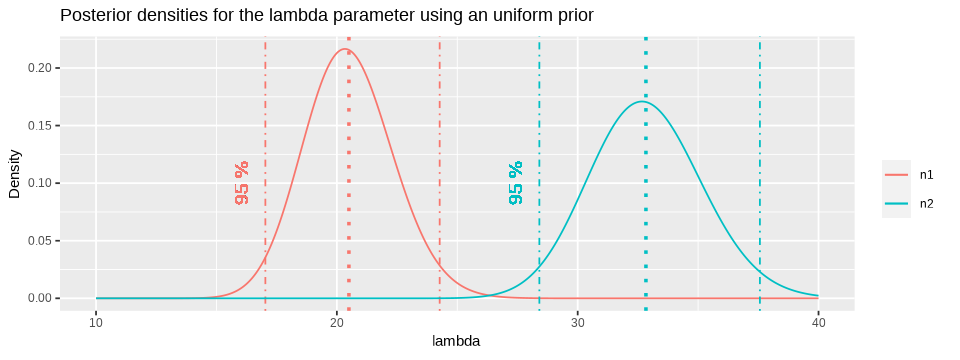

In [18]:
#print results
print_results("Uniform","n1",n1_mean_u,n1_median_u,n1_variance_u,n1_interval_u)
print("")
print_results("Uniform","n2",n2_mean_u,n2_median_u,n2_variance_u,n2_interval_u)

ggplot(results, aes(x = lambda)) +
    geom_line (aes(y = posterior_uniform_n1, color = 'n1')) +
    geom_vline(xintercept = n1_mean_u, color=color_n1, linetype="dotted", size = 1.0)+
    geom_vline(xintercept = n1_interval_u[1], color=color_n1, linetype="dotdash", size = 0.5)+
    geom_vline(xintercept = n1_interval_u[2], color=color_n1, linetype="dotdash", size = 0.5)+
    geom_text(mapping=aes(x=n1_interval_u[1]-1, y=0.1, label="95 %" ),colour=color_n1, size=5, angle=90)+

    geom_line (aes(y = posterior_uniform_n2, color = 'n2')) +
    geom_vline(xintercept = n2_mean_u, color=color_n2, linetype="dotted", size = 1.0)+
    geom_vline(xintercept = n2_interval_u[1], color=color_n2, linetype="dotdash", size = 0.5)+
    geom_vline(xintercept = n2_interval_u[2], color=color_n2, linetype="dotdash", size = 0.5)+
    geom_text(mapping=aes(x=n2_interval_u[1]-1, y=0.1, label="95 %" ),colour=color_n2, size=5, angle=90)+
    xlim(10,40)+
    labs(title ="Posterior densities for the lambda parameter using an uniform prior",
         x = "lambda",
         y = "Density",
         color = "") +
    scale_color_manual(values = colors)

###  assuming now a Jeffreys’ prior, $$ g(\lambda) \propto 1/\sqrt{\lambda}, \; with \; \lambda \gt 0$$  compute and plot the posterior distribution for λ, the death rate over the measurement time.  Determine the posterior mean, median and variance, and compute the 95% credibility interval.



In [19]:
lambda <- seq(0,40,0.01)
alpha_n1_j <- 0.5 + sum(data$n1 * data$death_soldiers)
beta_n1_j  <- length(data$n1)
alpha_n2_j <- 0.5 + sum(data$n2 * data$death_soldiers)
beta_n2_j  <- length(data$n2)

posterior_jeff_n1 <- dgamma(lambda,alpha_n1_j,beta_n1_j)
posterior_jeff_n2 <- dgamma(lambda,alpha_n2_j,beta_n2_j)

results <- data.frame(lambda, posterior_jeff_n1,posterior_jeff_n2)

In [20]:
n1_mean_j     <- gamma_mean(alpha_n1_j,beta_n1_j)
n1_variance_j <- gamma_variance(alpha_n1_j,beta_n1_j)
n1_median_j   <- posterior_median(lambda,posterior_jeff_n1)
n1_interval_j <- credibility_interval(0.95,lambda,posterior_jeff_n1)

n2_mean_j     <- gamma_mean(alpha_n2_j,beta_n2_j)
n2_variance_j <- gamma_variance(alpha_n2_j,beta_n2_j)
n2_median_j   <- posterior_median(lambda,posterior_jeff_n2)
n2_interval_j <- credibility_interval(0.95,lambda,posterior_jeff_n2)

--------------------------------- 
Type of prior: Uniform 
Dataset:       n1 
--------------------------------- 
Mean    20.417 
Median  20.360 
Variance  3.403 
95% confidence interval  [ 16.961 , 24.179 ] 
[1] ""
--------------------------------- 
Type of prior: Uniform 
Dataset:       n2 
--------------------------------- 
Mean    32.750 
Median  32.687 
Variance  5.458 
95% confidence interval  [ 28.328 , 37.476 ] 


Warning message:
“Removed 1000 row(s) containing missing values (geom_path).”Warning message:
“Removed 1000 row(s) containing missing values (geom_path).”

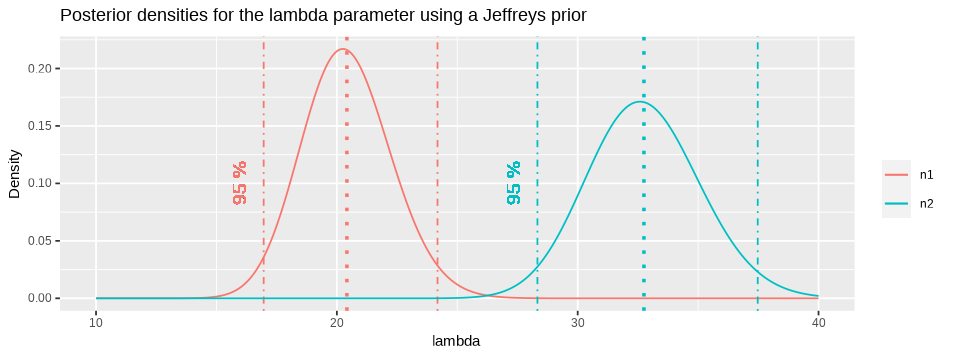

In [21]:
#print results
print_results("Uniform","n1",n1_mean_j,n1_median_j,n1_variance_j,n1_interval_j)
print("")
print_results("Uniform","n2",n2_mean_j,n2_median_j,n2_variance_j,n2_interval_j)

ggplot(results, aes(x = lambda)) +
    geom_line (aes(y = posterior_jeff_n1, color = 'n1')) +
    geom_vline(xintercept = n1_mean_j, color=color_n1, linetype="dotted", size = 1.0)+
    geom_vline(xintercept = n1_interval_j[1], color=color_n1, linetype="dotdash", size = 0.5)+
    geom_vline(xintercept = n1_interval_j[2], color=color_n1, linetype="dotdash", size = 0.5)+
    geom_text(mapping=aes(x=n1_interval_j[1]-1, y=0.1, label="95 %" ),colour=color_n1, size=5, angle=90)+

    geom_line (aes(y = posterior_jeff_n2, color = 'n2')) +
    geom_vline(xintercept = n2_mean_j, color=color_n2, linetype="dotted", size = 1.0)+
    geom_vline(xintercept = n2_interval_j[1], color=color_n2, linetype="dotdash", size = 0.5)+
    geom_vline(xintercept = n2_interval_j[2], color=color_n2, linetype="dotdash", size = 0.5)+
    geom_text(mapping=aes(x=n2_interval_j[1]-1, y=0.1, label="95 %" ),colour=color_n2, size=5, angle=90)+
    xlim(10,40)+
    labs(title ="Posterior densities for the lambda parameter using a Jeffreys prior",
         x = "lambda",
         y = "Density",
         color = "") +
    scale_color_manual(values = colors)

-

-

- 

-

-

##  Exercise 3

- A study on water quality of streams, a high level of bacter X was defined as a level greater than 100 per 100 ml of stream water. $n = 116$ samples were taken from streams having a high environmental impact on pandas. Out of these, $y = 11$ had a high bacter X level.

- indicating with $p$ the probability that a sample of water taken from the stream has a high bacter X level,


In [22]:
set_plot_dimensions(8, 3)
color_p      <- "#7CAE00"
color_p1     <- "#F8766D"
color_p2     <- "#00BFC4"
colors <- c('Posterior' = color_p, 'Posterior probability - Old prior' = color_p1, 'Posterior probability - beta(1,10) prior' = color_p2)

###  find the frequentist estimator for $p$


In [23]:
n <- 116
y <- 11

estimator <- y/n

print(paste("The frequentist estimator for p is",sprintf("%.3f",estimator)))

[1] "The frequentist estimator for p is 0.095"


### using a $\texttt{Beta}(1, 10)$ prior for $p$, calculate and posterior distribution $P (p|y)$


In [24]:
alpha_prior <- 1
beta_prior  <- 10

alpha_posterior <- alpha_prior + y
beta_posterior  <- beta_prior + n -y

p <- seq(0,1,0.001)
posterior <- dbeta(p,alpha_posterior,beta_posterior) 

df_1 <- data.frame(p,posterior)

###  find the bayesian estimator for $p$, the posterior mean and variance, and a 95% credible interval


In [25]:
beta_mean      <- function(a,b) {a / (a + b)}
beta_median    <- function(a,b) {if( a >= 1 & b > 1) {(a-1/3)/(a+b-(2/3))} else{cat("a or b =<1")}}
beta_mode      <- function(a,b) {if( a >= 1 & b > 1) {(a-1)/(a+b-2)} else{cat("a or b =<1")}}
beta_variance  <-  function(a,b) {(a * b) / ((a + b)**2 * (a + b + 1))}

credibility_interval <- function(credibility,p,posterior){
    #credibility must be between 0 and 1
    cdf  <- sintegral(p,posterior)
    a <- (1-credibility)/2
    b <- (credibility + a)
    d<-abs(cdf$y-a)
    posterior.min <- cdf$x[max((1:length(cdf$y))[d==min(d)])]

    d<-abs(cdf$y-b)
    posterior.max <- cdf$x[max((1:length(cdf$y))[d==min(d)])]
    return(c(posterior.min,posterior.max))}

interval_hipothesis_evaluation <- function(posicion,intervalo) {
    if (posicion > intervalo[1] & posicion < intervalo[2] ){
    cat(paste("The value",sprintf("%.2f",posicion),"is inside the 95 % confidence interval of the bayesian approach."))
    
}else{cat(paste("The value",sprintf("%.2f",posicion),"is NOT inside the 95 % confidence interval of the bayesian approach. "))}
}

In [26]:
posterior_mean      <- beta_mean(alpha_posterior,beta_posterior)
posterior_variance  <- beta_variance(alpha_posterior,beta_posterior)

interval <- credibility_interval(0.95,p,posterior)


In [27]:
cat("----------------------------\n")
cat("Under the bayesian approach: \n")
cat("----------------------------\n")

cat(paste("Mean     ",sprintf("%.5f",posterior_mean)),"\n")
cat(paste("Variance ",sprintf("%.5f",posterior_variance)),"\n")
cat(paste("95% confidence interval ","[",sprintf("%.3f",interval[1]),",",sprintf("%.3f",interval[2]),"]"),"\n")



----------------------------
Under the bayesian approach: 
----------------------------
Mean      0.09449 
Variance  0.00067 
95% confidence interval  [ 0.049 , 0.150 ] 


###  test the hypotesis $$H_o : p = 0.1 \; \text{versus} \; H_1 : p \neq0.1$$ at 5% level of significance with both the frequentist and bayesian approach

In [28]:
p_test <- 0.1

- Frequentist 

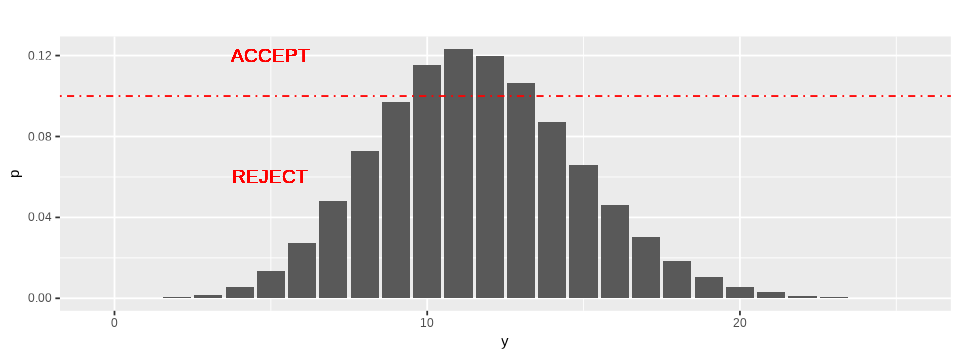

In [29]:
y <- seq(0,25,1)
f_test <- dbinom(x = y, size = n, prob = p_test)

ggplot(data.frame(y,f_test),aes(x = y)) + 
    geom_bar(aes(y = f_test),stat="identity")+
    geom_hline(yintercept = p_test, color="red", linetype="dotdash", size = 0.5)+
    geom_text(mapping=aes(x=5, y=0.12, label="ACCEPT" ),colour="red", size=5)+
    geom_text(mapping=aes(x=5, y=0.06, label="REJECT" ),colour="red", size=5)+
    #geom_vline(yintercept = p_test, color="red", linetype="dotdash", size = 0.5)+

    
labs(title ="",
         x = "y",
         y = "p",
         color = "Set")

- Bayesian

The value 0.10 is inside the 95 % confidence interval of the bayesian approach.

Warning message:
“Removed 750 row(s) containing missing values (geom_path).”

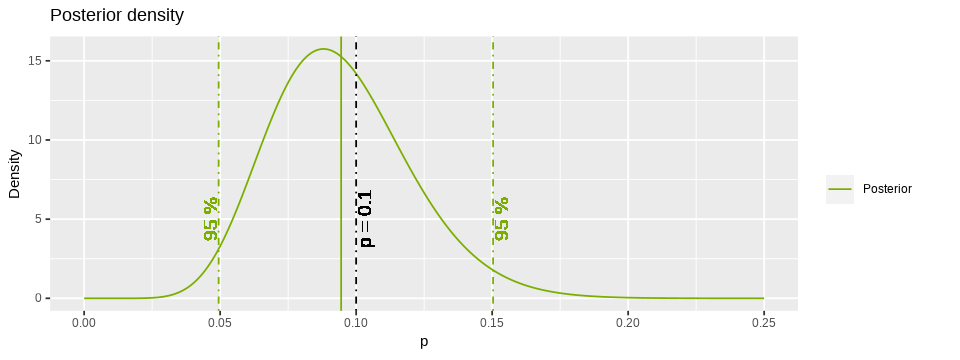

In [30]:
interval_hipothesis_evaluation(p_test,interval)

ggplot(df_1, aes(x = p)) +
    geom_line (aes(y = posterior, color = 'Posterior')) +
    geom_vline(xintercept = posterior_mean, color=color_p, size = 0.5)+
    geom_vline(xintercept = interval[1], color=color_p, linetype="dotdash", size = 0.5)+
    geom_text(mapping=aes(x=interval[1]-0.003, y=5, label="95 %" ),colour=color_p, size=5, angle=90)+
    geom_vline(xintercept = interval[2], color=color_p, linetype="dotdash", size = 0.5)+
    geom_text(mapping=aes(x=interval[2]+0.003, y=5, label="95 %" ),colour=color_p, size=5, angle=90)+

    geom_vline(xintercept = p_test, color="black", linetype="dotdash", size = 0.5)+
    geom_text(mapping=aes(x=p_test+0.003, y=5, label="p = 0.1" ),colour="black", size=5, angle=90)+
    xlim(0,0.25)+
    labs(title ="Posterior density",
         x = "p",
         y = "Density",
         color = "") +
    scale_color_manual(values = colors)


-  a new measurement, performed one month later on $n = 165$ water samples, gives $y = 9$ high bacter X level


### find the frequentist estimator for p


In [31]:
n <- 165
y <- 9

estimator <- y/n

print(paste("The frequentist estimator for p is",sprintf("%.3f",estimator)))

[1] "The frequentist estimator for p is 0.055"


###  find a bayesian estimator for $p$, assuming both a $Beta(1, 10)$ prior for $p$, and assuming the posterior probability of the older measurement as the prior for the new one.


### find the bayesian estimator for $p$, the posterior mean and variance, and a 95% credible interval


###  test the hypotesis $$H_o : p = 0.1 \; \text{versus} \; H_1 : p \neq0.1$$ at 5% level of significance with both the frequentist and bayesian approach

- Using the previous posterior as a prior 

In [32]:
#We are taking the previous posterior parameters as the new prior parameters
alpha_prior <- alpha_posterior  
beta_prior  <- beta_posterior

alpha_posterior <- alpha_prior + y
beta_posterior  <- beta_prior + n -y

p <- seq(0,1,0.001)
posterior_1 <- dbeta(p,alpha_posterior,beta_posterior) 



In [33]:
posterior_mean_1      <- beta_mean(alpha_posterior,beta_posterior)
posterior_variance_1  <- beta_variance(alpha_posterior,beta_posterior)
interval_1 <- credibility_interval(0.95,p,posterior_1)

In [34]:
cat("----------------------------\n")
cat("Using the previous posterior as a prior: \n")
cat("Under the bayesian approach: \n")
cat("----------------------------\n")

cat(paste("Mean     ",sprintf("%.4f",posterior_mean_1)),"\n")
cat(paste("Variance ",sprintf("%.4f",posterior_variance_1)),"\n")
cat(paste("95% confidence interval ","[",sprintf("%.3f",interval_1[1]),",",sprintf("%.3f",interval_1[2]),"]"),"\n")


----------------------------
Using the previous posterior as a prior: 
Under the bayesian approach: 
----------------------------
Mean      0.0719 
Variance  0.0002 
95% confidence interval  [ 0.044 , 0.103 ] 


- Using $Beta(1,10)$ as a prior

In [35]:
#We are taking the previous posterior parameters as the new prior parameters
alpha_prior <- 1 
beta_prior  <- 10

alpha_posterior <- alpha_prior + y
beta_posterior  <- beta_prior + n -y

p <- seq(0,1,0.001)
posterior_2 <- dbeta(p,alpha_posterior,beta_posterior) 


In [36]:
posterior_mean_2      <- beta_mean(alpha_posterior,beta_posterior)
posterior_variance_2  <- beta_variance(alpha_posterior,beta_posterior)
interval_2 <- credibility_interval(0.95,p,posterior_2)

In [37]:
cat("----------------------------\n")
cat("Using  beta(1,10)  as a prior: \n")
cat("Under the bayesian approach: \n")
cat("----------------------------\n")

cat(paste("Mean     ",sprintf("%.4f",posterior_mean_2)),"\n")
cat(paste("Variance ",sprintf("%.4f",posterior_variance_2)),"\n")
cat(paste("95% confidence interval ","[",sprintf("%.3f",interval_2[1]),",",sprintf("%.3f",interval_2[2]),"]"),"\n")


----------------------------
Using  beta(1,10)  as a prior: 
Under the bayesian approach: 
----------------------------
Mean      0.0568 
Variance  0.0003 
95% confidence interval  [ 0.027 , 0.094 ] 


Using the Bayesian approach: 
 
Using the previous posterior as a prior we obtain that: 
The value 0.10 is inside the 95 % confidence interval of the bayesian approach.
 
Using beta(1,10)  as a prior we obtain that: 
The value 0.10 is NOT inside the 95 % confidence interval of the bayesian approach. 

Warning message:
“Removed 850 row(s) containing missing values (geom_path).”Warning message:
“Removed 850 row(s) containing missing values (geom_path).”

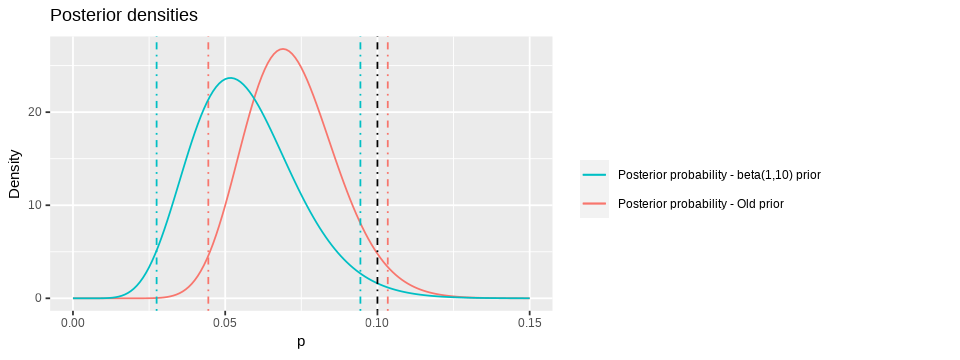

In [38]:
df <- data.frame(p,posterior_1,posterior_2)
cat("Using the Bayesian approach: \n \n" )
cat("Using the previous posterior as a prior we obtain that: \n")
interval_hipothesis_evaluation(p_test,interval_1)
cat("\n \n")
cat("Using beta(1,10)  as a prior we obtain that: \n")
interval_hipothesis_evaluation(p_test,interval_2)

ggplot(df, aes(x = p)) +
    geom_line (aes(y = posterior_1, color = 'Posterior probability - Old prior')) +
    geom_vline(xintercept = interval_1[1], color=color_p1, linetype="dotdash", size = 0.5)+
    geom_vline(xintercept = interval_1[2], color=color_p1, linetype="dotdash", size = 0.5)+

    geom_line (aes(y = posterior_2, color = 'Posterior probability - beta(1,10) prior')) +
    geom_vline(xintercept = interval_2[1], color=color_p2, linetype="dotdash", size = 0.5)+
    geom_vline(xintercept = interval_2[2], color=color_p2, linetype="dotdash", size = 0.5)+

    geom_vline(xintercept = p_test, color="black", linetype="dotdash", size = 0.5)+
    xlim(0,0.15)+
    labs(title ="Posterior densities",
         x = "p",
         y = "Density",
         color = "") +
    scale_color_manual(values = colors)


Using the frequentist approach 
 
Old prior 
Beta(1,10) prior 


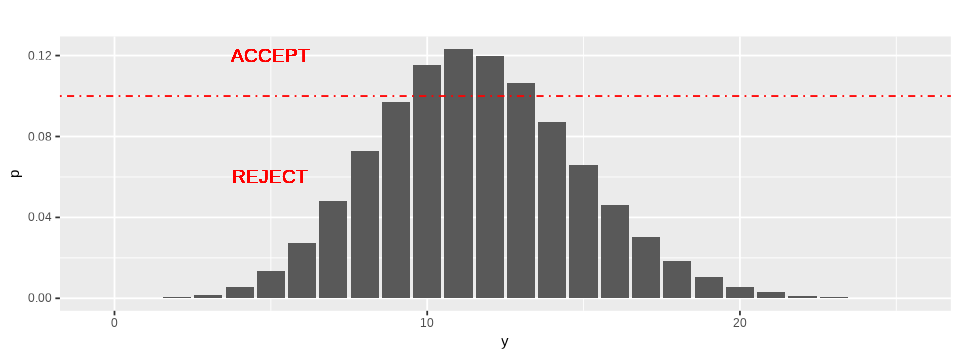

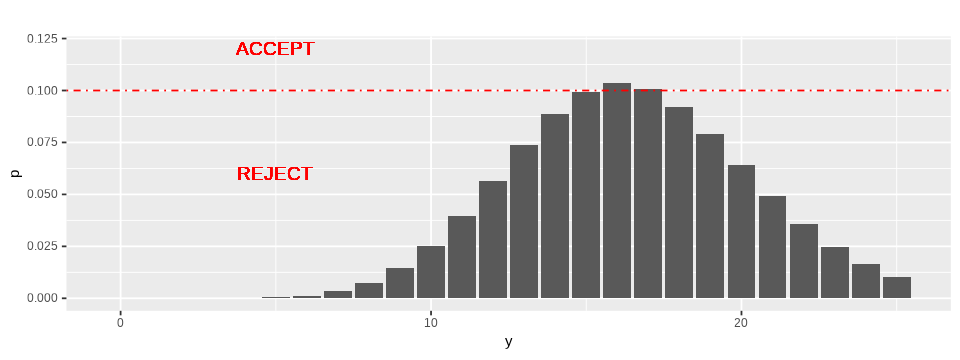

In [39]:
cat("Using the frequentist approach \n \n")
cat("Old prior \n")

y <- seq(0,25,1)
f_test <- dbinom(x = y, size = 116, prob = p_test)

ggplot(data.frame(y,f_test),aes(x = y)) + 
    geom_bar(aes(y = f_test),stat="identity")+
    geom_hline(yintercept = p_test, color="red", linetype="dotdash", size = 0.5)+
    geom_text(mapping=aes(x=5, y=0.12, label="ACCEPT" ),colour="red", size=5)+
    geom_text(mapping=aes(x=5, y=0.06, label="REJECT" ),colour="red", size=5)+
    #geom_vline(yintercept = p_test, color="red", linetype="dotdash", size = 0.5)+

    
labs(title ="",
         x = "y",
         y = "p",
         color = "Set")


cat("Beta(1,10) prior \n")

y <- seq(0,25,1)
f_test <- dbinom(x = y, size = n, prob = p_test)

ggplot(data.frame(y,f_test),aes(x = y)) + 
    geom_bar(aes(y = f_test),stat="identity")+
    geom_hline(yintercept = p_test, color="red", linetype="dotdash", size = 0.5)+
    geom_text(mapping=aes(x=5, y=0.12, label="ACCEPT" ),colour="red", size=5)+
    geom_text(mapping=aes(x=5, y=0.06, label="REJECT" ),colour="red", size=5)+
    #geom_vline(yintercept = p_test, color="red", linetype="dotdash", size = 0.5)+

    
labs(title ="",
         x = "y",
         y = "p",
         color = "Set")